In [1]:
#BASCO, ISAIAH JESS L. 
#Importing Libraries Needed
from sklearn.metrics import mean_squared_error, mean_absolute_error, explained_variance_score, r2_score, mean_gamma_deviance
from itertools import cycle
import plotly.express as px
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import dates as mpl_dates
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.layers import LSTM
import math

In [2]:
dataset = pd.read_csv('Prices.csv')

In [3]:
print(dataset)

           Date   Open   High   Low   Close  Adj Close    Volume
0     10/7/2022   3.53   3.53  3.43    3.45   0.636962   6462000
1     10/6/2022   3.50   3.55  3.46    3.54   0.636962   5108000
2     10/5/2022   3.45   3.45  3.40    3.45   0.636962  11404000
3     10/4/2022   3.35   3.44  3.35    3.43   0.636962   6187000
4     10/3/2022   3.35   3.44  3.30    3.30   0.435392  11060000
..          ...    ...    ...   ...     ...        ...       ...
485  10/16/2020   3.92   4.01  3.87    4.01   1.540000  74540000
486  10/15/2020   3.95   3.99  3.87    3.97   1.540000  61833000
487  10/14/2020   3.81   3.96  3.80    3.95   1.540000  57333000
488  10/13/2020   3.87   3.93  3.76    3.76   1.540000  61226000
489  10/12/2020   4.04   4.04  3.87    3.87   1.540000  63970000

[490 rows x 7 columns]


In [4]:
dataset.isnull().sum()

Date         0
 Open        0
 High        0
 Low         0
 Close       0
Adj Close    0
 Volume      0
dtype: int64

In [5]:
dataset.describe()

,Open,High,Low,Close,Adj Close,Volume
count,490.000000,490.000000,490.000000,490.000000,490.000000,4.900000e+02
mean,3.892204,3.932673,3.844551,3.885571,1.170459,2.023703e+07
std,0.211688,0.213095,0.207624,0.214545,0.346804,1.601401e+07
min,3.350000,3.440000,3.300000,3.300000,0.435392,2.689000e+06
25%,3.750000,3.790000,3.710000,3.750000,0.906981,1.024900e+07
50%,3.860000,3.895000,3.810000,3.850000,1.241596,1.582050e+07
75%,4.010000,4.060000,3.970000,4.010000,1.448350,2.483675e+07
max,4.540000,4.580000,4.450000,4.550000,1.655257,1.719530e+08


In [6]:
dataset.reset_index(inplace=True)

In [7]:
dataset

,index,Date,Open,High,Low,Close,Adj Close,Volume
0,0,10/7/2022,3.53,3.53,3.43,3.45,0.636962,6462000
1,1,10/6/2022,3.50,3.55,3.46,3.54,0.636962,5108000
2,2,10/5/2022,3.45,3.45,3.40,3.45,0.636962,11404000
3,3,10/4/2022,3.35,3.44,3.35,3.43,0.636962,6187000
4,4,10/3/2022,3.35,3.44,3.30,3.30,0.435392,11060000
...,...,...,...,...,...,...,...,...
485,485,10/16/2020,3.92,4.01,3.87,4.01,1.540000,74540000
486,486,10/15/2020,3.95,3.99,3.87,3.97,1.540000,61833000
487,487,10/14/2020,3.81,3.96,3.80,3.95,1.540000,57333000
488,488,10/13/2020,3.87,3.93,3.76,3.76,1.540000,61226000


In [8]:
dataset_adj_close=dataset['Adj Close']

In [9]:
dataset_adj_close

0      0.636962
1      0.636962
2      0.636962
3      0.636962
4      0.435392
         ...   
485    1.540000
486    1.540000
487    1.540000
488    1.540000
489    1.540000
Name: Adj Close, Length: 490, dtype: float64

In [10]:
dataset = pd.DataFrame(dataset, columns=["Date","Adj Close"])

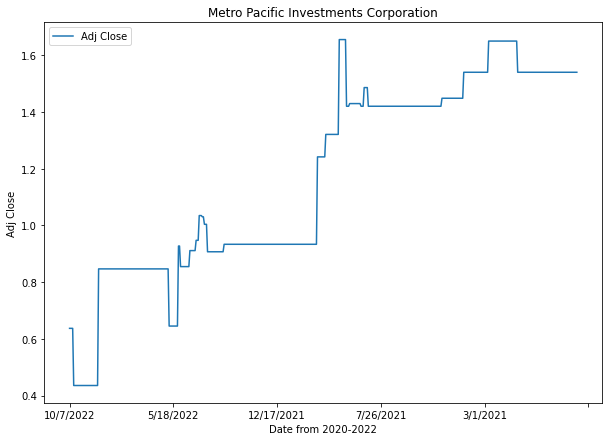

In [11]:
dataset.plot(x='Date',y=["Adj Close"],kind="line", figsize=(10, 7))
plt.title("Metro Pacific Investments Corporation")
plt.xlabel("Date from 2020-2022")
plt.ylabel("Adj Close")
plt.show()

In [12]:

from sklearn.preprocessing import MinMaxScaler
scaler=MinMaxScaler(feature_range=(0,1))
dataset_adj_close=scaler.fit_transform(np.array(dataset_adj_close).reshape(-1,1))

In [13]:
dataset_adj_close.shape

(490, 1)

In [14]:

train_size=int(len(dataset_adj_close)*0.70)
test_size=len(dataset_adj_close)-train_size
train_data=dataset_adj_close[0:train_size,:]
test_data=dataset_adj_close[train_size:len(dataset_adj_close),:1]

In [79]:
print(train_size,test_size)
print("train_data: ", train_data.shape)
print("test_data: ", test_data.shape)

343 147
train_data:  (343, 1)
test_data:  (147, 1)


In [83]:
def new_dataset(df2, time_step=1):
    x_data, y_data = [], []
    for i in range(len(df2)-time_step-1): 
        x_data.append(df2[i:(i+time_step), 0])
        y_data.append(df2[i + time_step, 0])
    return np.array(x_data), np.array(y_data)

In [17]:
time_step= 60
X_train, y_train= new_dataset(train_data, time_step)
X_test, y_test= new_dataset(test_data, time_step)

In [77]:

print("X_train: ",X_train.shape,"\ny_train: ", y_train.shape)


X_train:  (282, 60, 1) 
y_train:  (282,)


In [78]:
print("X_test: ",X_test.shape,"\ny_test: ", y_test.shape)

X_test:  (86, 60, 1) 
y_test:  (86,)


In [19]:
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)

In [20]:
print("X_train: ",X_train.shape,"\ny_train: ", y_train.shape)
print("X_test: ",X_test.shape,"\ny_test: ", y_test.shape)

X_train:  (282, 60, 1) 
y_train:  (282,)
X_test:  (86, 60, 1) 
y_test:  (86,)


In [21]:
#Structure of model
model=Sequential()
model.add(LSTM(20,return_sequences=True,input_shape=(time_step,1)))
model.add(LSTM(20,return_sequences=True))
model.add(LSTM(20))
model.add(Dense(1))
model.compile(loss='mean_squared_error',optimizer='adam')

In [22]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 60, 20)            1760      
                                                                 
 lstm_1 (LSTM)               (None, 60, 20)            3280      
                                                                 
 lstm_2 (LSTM)               (None, 20)                3280      
                                                                 
 dense (Dense)               (None, 1)                 21        
                                                                 
Total params: 8,341
Trainable params: 8,341
Non-trainable params: 0
_________________________________________________________________


In [23]:
#Model Fitting
model.fit(X_train,y_train,validation_data=(X_test,y_test),epochs=160,batch_size=32,verbose=1)

Epoch 1/160
9/9 [==============================] - 12s 358ms/step - loss: 0.1863 - val_loss: 0.0984
Epoch 2/160
9/9 [==============================] - 1s 93ms/step - loss: 0.0331 - val_loss: 0.0022
Epoch 3/160
9/9 [==============================] - 1s 87ms/step - loss: 0.0143 - val_loss: 0.0695
Epoch 4/160
9/9 [==============================] - 1s 84ms/step - loss: 0.0159 - val_loss: 0.0134
Epoch 5/160
9/9 [==============================] - 1s 88ms/step - loss: 0.0113 - val_loss: 0.0060
Epoch 6/160
9/9 [==============================] - 1s 85ms/step - loss: 0.0090 - val_loss: 0.0132
Epoch 7/160
9/9 [==============================] - 1s 84ms/step - loss: 0.0075 - val_loss: 0.0021
Epoch 8/160
9/9 [==============================] - 1s 81ms/step - loss: 0.0069 - val_loss: 0.0026
Epoch 9/160
9/9 [==============================] - 1s 82ms/step - loss: 0.0063 - val_loss: 0.0016
Epoch 10/160
9/9 [==============================] - 1s 85ms/step - loss: 0.0061 - val_loss: 0.0016
Epoch 11/160
9/9 

9/9 [==============================] - 1s 85ms/step - loss: 0.0038 - val_loss: 0.0012
Epoch 84/160
9/9 [==============================] - 1s 81ms/step - loss: 0.0038 - val_loss: 0.0010
Epoch 85/160
9/9 [==============================] - 1s 85ms/step - loss: 0.0038 - val_loss: 0.0054
Epoch 86/160
9/9 [==============================] - 1s 82ms/step - loss: 0.0039 - val_loss: 0.0015
Epoch 87/160
9/9 [==============================] - 1s 85ms/step - loss: 0.0038 - val_loss: 6.9088e-04
Epoch 88/160
9/9 [==============================] - 1s 84ms/step - loss: 0.0042 - val_loss: 0.0014
Epoch 89/160
9/9 [==============================] - 1s 82ms/step - loss: 0.0045 - val_loss: 0.0040
Epoch 90/160
9/9 [==============================] - 1s 82ms/step - loss: 0.0040 - val_loss: 0.0039
Epoch 91/160
9/9 [==============================] - 1s 81ms/step - loss: 0.0038 - val_loss: 0.0039
Epoch 92/160
9/9 [==============================] - 1s 82ms/step - loss: 0.0038 - val_loss: 8.9234e-04
Epoch 93/160
9/

In [ ]:
train_predict=model.predict(X_train)
test_predict=model.predict(X_test)

In [ ]:
train_predict=scaler.inverse_transform(train_predict)
test_predict=scaler.inverse_transform(test_predict)

In [26]:
import math
from sklearn.metrics import mean_squared_error
math.sqrt(mean_squared_error(y_train,train_predict))

0.5555505118496559

In [27]:
#DATA TESTING
math.sqrt(mean_squared_error(y_test,test_predict))

0.5775015102468208

In [75]:
#Training of prediction plot
look_back=60
trainPredictPlot= np.empty_like(dataset_adj_close)
trainPredictPlot[:, :]= np.nan
trainPredictPlot[look_back:len(train_predict)+look_back, :]= train_predict
#Test predictions for plot
testPredictPlot = np.empty_like(dataset_adj_close)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(train_predict)+(look_back*2)+1:len(dataset_adj_close)-1, :] = test_predict


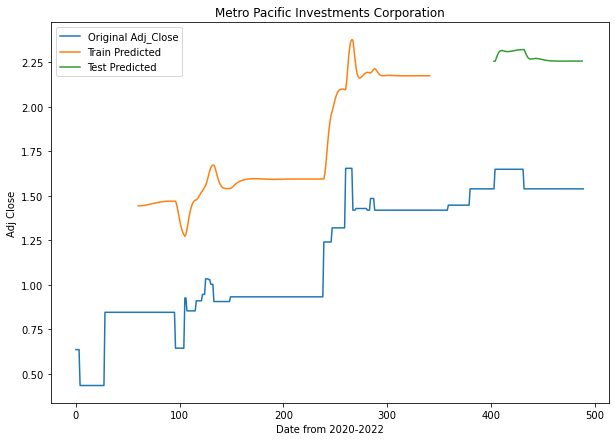

In [76]:
#Plotting
plt.title("Metro Pacific Investments Corporation")
plt.xlabel("Date from 2020-2022")
plt.ylabel("Adj Close")
plt.plot(scaler.inverse_transform(dataset_adj_close))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.gca().legend(('Original Adj_Close','Train Predicted','Test Predicted'))
plt.rcParams['figure.figsize'] = [10, 7]
plt.show()

In [32]:
#Prediction
train_predict=model.predict(X_train)
test_predict=model.predict(X_test)
train_predict.shape, test_predict.shape

3/3 [==============================] - 0s 19ms/step


((282, 1), (86, 1))

In [73]:
train_predict = scaler.inverse_transform(train_predict)
test_predict = scaler.inverse_transform(test_predict)


In [74]:
original_ytrain = scaler.inverse_transform(y_train.reshape(-1,1)) 
original_ytest = scaler.inverse_transform(y_test.reshape(-1,1))

In [34]:
#Metrices Evaluation
print("Train data RMSE: ", math.sqrt(mean_squared_error(original_ytrain,train_predict)))
print("Train data MSE: ", mean_squared_error(original_ytrain,train_predict))
print("Test data MAE: ", mean_absolute_error(original_ytrain,train_predict))

Train data RMSE:  0.0590889974181386
Train data MSE:  0.0034915096158807902
Test data MAE:  0.03152754118356641


In [35]:
print("Test data RMSE: ", math.sqrt(mean_squared_error(original_ytest,test_predict)))
print("Test data MSE: ", mean_squared_error(original_ytest,test_predict))
print("Test data MAE: ", mean_absolute_error(original_ytest,test_predict))

Test data RMSE:  0.07327511504342045
Test data MSE:  0.005369242484626502
Test data MAE:  0.06422520171764284


In [50]:
#Prediction
x_input=test_data[len(test_data)-time_step:].reshape(1,-1)
temp=list(x_input)
temp=temp[0].tolist()
from numpy import array
lst_output=[]
n_steps=time_step
i=0
pred_days= 10
while(i<pred_days):
    if(len(temp)>time_step):
        x_input=np.array(temp[1:])
        x_input = x_input.reshape(1,-1)
        x_input = x_input.reshape((1, n_steps, 1))
        yhat = model.predict(x_input, verbose=0)
        temp.extend(yhat[0].tolist())
        temp=temp[1:]       
        lst_output.extend(yhat.tolist())
        i=i+1     
    else: 
        x_input = x_input.reshape((1, n_steps,1))
        yhat = model.predict(x_input, verbose=0)
        temp.extend(yhat[0].tolist())
        lst_output.extend(yhat.tolist())
        i=i+1

In [51]:
print("Days to be Predict: ", len(lst_output))

Days to be Predict:  10


In [52]:
last_days=np.arange(1,time_step+1)
day_pred=np.arange(time_step+1,time_step+pred_days+1)

In [71]:
temp_mat= np.empty((len(last_days)+pred_days+1,1))
temp_mat[:]= np.nan
temp_mat= temp_mat.reshape(1,-1).tolist()[0]
last_original_days_value= temp_mat
next_predicted_days_value= temp_mat
last_original_days_value[0:time_step+1]= scaler.inverse_transform(dataset_adj_close[len(dataset_adj_close)-time_step:]).reshape(1,-1).tolist()[0]
next_predicted_days_value[time_step+1:]= scaler.inverse_transform(np.array(lst_output).reshape(-1,1)).reshape(1,-1).tolist()[0]
new_pred_plot= pd.DataFrame({'last_original_days_value':last_original_days_value,'next_predicted_days_value':next_predicted_days_value})
names= cycle(['Last 15 days close price','Predicted next 10 days close price'])

In [84]:
fig= px.line(new_pred_plot,x=new_pred_plot.index,
            y=[new_pred_plot['last_original_days_value'],
            new_pred_plot['next_predicted_days_value']],
            labels={'value': 'Stock price','index': 'Day'})
fig.update_layout(title_text='Last 15 days vs next 10 days',
plot_bgcolor='white', font_size=15, font_color='black',legend_title_text='Adj_Close Price')
fig.for_each_trace(lambda t:  t.update(name= next(names)))
fig.show()

In [54]:
output=scaler.inverse_transform(lst_output)

In [70]:
#FOR THE OUTPUT NEEDED
data= {'Adj_Close': output}
df= pd.DataFrame(data=output)
df.columns = ["Adj_Close"]

In [69]:
Date=["10-11-2022","10-12-2022","10-13-2022","10-14-2022","10-15-2022","10-16-2022",
      "10-17-2022","10-18-2022","10-19-2022","10-20-2022"]
df.insert(loc=1,column="Date", value=Date)

In [66]:
print("The predicted output starting from October 11, 2022 to October  20, 2022 are:\n\n",df[1:9],"\n")

The predicted output starting from October 11, 2022 to October  20, 2022 are:

    Adj_Close        Date
1   1.489510  10-12-2022
2   1.483797  10-13-2022
3   1.478130  10-14-2022
4   1.473185  10-15-2022
5   1.469194  10-16-2022
6   1.466144  10-17-2022
7   1.463903  10-18-2022
8   1.462297  10-19-2022 

